In [1]:
!pip install -U jaxlib[cuda112]==0.3.15 -f https://storage.googleapis.com/jax-releases/jax_cuda_releases.html
!pip install -U jax[cuda112]==0.3.17 -f https://storage.googleapis.com/jax-releases/jax_cuda_releases.html
!pip install optax
!pip install dm-haiku
!pip install tensorflow-probability==0.17
!pip install git+https://github.com/blackjax-devs/blackjax.git
!apt update
!apt install -y graphviz
!apt-get -y install swig
!pip install smac
!pip install graphviz
!pip install gplearn

Looking in links: https://storage.googleapis.com/jax-releases/jax_cuda_releases.html
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 162.7/162.7 MB 13.5 MB/s eta 0:00:0000:0100:01
  Attempting uninstall: jaxlib
    Found existing installation: jaxlib 0.3.8+cuda11.cudnn82
    Uninstalling jaxlib-0.3.8+cuda11.cudnn82:
      Successfully uninstalled jaxlib-0.3.8+cuda11.cudnn82
Looking in links: https://storage.googleapis.com/jax-releases/jax_cuda_releases.html
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 62.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for jax: filename=jax-0.3.17-py3-none-any.whl size=1217849 sha256=b3c9a976db17c191e23c35f155901cc69d126540cdb47daccbd700a3e9ae6c78
  Stored in directory: /root/.cache/pip/wheels/36/cd/88/2d90379f7549c27d5654e893f74210f30f0c645c23a71e6f56
Successfully built jax
  Attempting uninstall: jax
    Found existing installation: jax 0.3.14
    Uninstalling jax-0.3.14:
      Successfully uninstalled jax-0.3.14
  

In [1]:
import os
os.environ["XLA_PYTHON_CLIENT_PREALLOCATE"] = "False"
os.environ["XLA_PYTHON_CLIENT_ALLOCATOR"] = "platform"
SERVER = 0

if not SERVER:
    %cd /home/xabush/code/snet/moses-incons-pen-xp/notebooks/variable_selection/cancer/nn

import pandas as pd
import matplotlib.pyplot as plt
import tensorflow_probability.substrates.jax as tfp
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold, KFold, GridSearchCV
from sklearn.preprocessing import StandardScaler
tfd = tfp.distributions
import jax
import haiku as hk
import numpy as np
import optax
from nn_util import *
from optim_util import *
plt.style.use('ggplot')
%load_ext autoreload

/home/xabush/code/snet/moses-incons-pen-xp/notebooks/variable_selection/cancer/nn


/home/xabush/miniconda3/lib/python3.9/site-packages/chex/_src/pytypes.py:37: FutureWarning: jax.tree_structure is deprecated, and will be removed in a future release. Use jax.tree_util.tree_structure instead.
  PyTreeDef = type(jax.tree_structure(None))


In [2]:
if SERVER:
    data_dir = "."
else:
    data_dir = "/home/xabush/code/snet/moses-incons-pen-xp/data"

%env JAX_ENABLE_X64=True

env: JAX_ENABLE_X64=True


### GDSC Cell Line

#### Tamoxifen

In [3]:
gdsc_dir = f"{data_dir}/cell_line/gdsc2"
gdsc_exp_tamox_data = pd.read_csv(f"{gdsc_dir}/tamoxifen_response_gene_expr.csv")
gdsc_exp_tamox_data.shape

(406, 37265)

In [4]:
X, target = gdsc_exp_tamox_data.iloc[:,:-1], gdsc_exp_tamox_data.iloc[:,-1]
# change to -log10(IC_50) to make it comparable
target = -np.log10(np.exp(target)) # exp b/c the values are natural logs of raw IC_50

In [5]:
cancer_driver_genes_df = pd.read_csv(f"{data_dir}/cell_line/driver_genes_20221018.csv")
cancer_driver_genes_df

,symbol,method_of_action,cosmic_moa,intogen_moa,gene_id
0,ABCB1,Act,NaN,Act,SIDG00064
1,ABI1,ambiguous,"TSG, fusion",ambiguous,SIDG00145
2,ABL1,Act,"oncogene, fusion",Act,SIDG00150
3,ABL2,Act,"oncogene, fusion",Act,SIDG00151
4,ACKR3,Act,"oncogene, fusion",Act,SIDG00205
...,...,...,...,...,...
778,ZNF814,Act,NaN,Act,SIDG42334
779,ZNF93,LoF,NaN,LoF,SIDG41755
780,ZNRF3,LoF,NaN,LoF,SIDG42403
781,ZRSR2,LoF,TSG,LoF,SIDG42422


In [6]:
cols = X.columns.to_list()
driver_syms = cancer_driver_genes_df["symbol"].to_list()
sym_list = [sym.strip() for sym in cols if sym in driver_syms]

In [7]:
X_selected = X[sym_list]
X_selected.shape

(406, 768)

#### Data Preprocessing

In [8]:
seed = 739
X_train_outer_df, X_test_df, y_train_outer_df, y_test_df = train_test_split(X_selected, target, random_state=seed, shuffle=True, test_size=0.2)

In [9]:
from sklearn.preprocessing import QuantileTransformer, PowerTransformer, RobustScaler, MinMaxScaler, Normalizer, StandardScaler

train_transformer = QuantileTransformer(random_state=seed, output_distribution="normal").fit(X_train_outer_df)
# train_transformer = PowerTransformer().fit(X_train_df)
train_transformed = train_transformer.transform(X_train_outer_df)
test_transformed = train_transformer.transform(X_test_df)

X_train_outer_df = pd.DataFrame(train_transformed, columns=X_train_outer_df.columns)
X_test_df = pd.DataFrame(test_transformed, columns=X_test_df.columns)

/home/xabush/miniconda3/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:2583: UserWarning: n_quantiles (1000) is greater than the total number of samples (324). n_quantiles is set to n_samples.
  warnings.warn(


In [10]:
X_train_df, X_val_df, y_train_df, y_val_df = train_test_split(X_train_outer_df, y_train_outer_df, shuffle=True,
                                                              random_state=seed, test_size=0.2)
train_indices, val_indices = X_train_df.index.to_list(), X_val_df.index.to_list()

In [11]:
X_train_outer, y_train_outer = X_train_outer_df.values, y_train_outer_df.values
X_train, y_train = X_train_df.values, y_train_df.values
X_val, y_val = X_val_df.values, y_val_df.values
X_test, y_test = X_test_df.values, y_test_df.values

In [117]:
class ResnetState(NamedTuple):
    params: hk.Params
    opt_state: hk.Params
    net_state: hk.State

class ResNetBlock(hk.Module):
    def __init__(self, act_fn, dim, init_fn, dropout_rate, name=None):
        super().__init__(name)
        self.act_fn = act_fn
        self.dim = dim
        self.init_fn = init_fn
        self.dropout_rate = dropout_rate

    def __call__(self, x, is_training):
        key = hk.next_rng_key()
        subkey1, subkey2 = jax.random.split(key, 2)
        z = hk.Linear(self.dim, w_init=self.init_fn, with_bias=False)(x)
        z = hk.BatchNorm(True, True, 0.9)(z, is_training)
        z = self.act_fn(z)
        if is_training:
            z = hk.dropout(subkey1, self.dropout_rate, z)
        z = hk.Linear(self.dim, w_init=self.init_fn, with_bias=False)(z)
        if is_training:
            z = hk.dropout(subkey2, self.dropout_rate, z)
        x_out = self.act_fn(z + x)
        return x_out

class PreActResNetBlock(ResNetBlock):

    def __init__(self, act_fn, dim, init_fn, dropout_rate, name=None):
        super().__init__(act_fn, dim, init_fn, dropout_rate, name)


    def __call__(self, x, is_training):
        key = hk.next_rng_key()
        subkey1, subkey2, subkey3 = jax.random.split(key, 3)
        z = hk.BatchNorm(True, True, 0.9)(x, is_training)
        z = self.act_fn(z)
        if is_training:
            z = hk.dropout(subkey1, self.dropout_rate, z)
        z = hk.Linear(self.dim, w_init=self.init_fn, with_bias=False)(z)
        z = hk.BatchNorm(True, True, 0.9)(z, is_training)
        z = self.act_fn(z)
        if is_training:
            z = hk.dropout(subkey2, self.dropout_rate, z)
        z = hk.Linear(self.dim, w_init=self.init_fn, with_bias=False)(z)
        if is_training:
            z = hk.dropout(subkey3, self.dropout_rate, z)
        x_out = z + x
        return x_out


class ResNet:
    def __init__(self, block_class, num_blocks, hidden_dims,
                 optim, init_fn, act_fn, dropout_rate):

        self.block_class = block_class
        self.num_blocks = num_blocks
        self.hidden_dims = hidden_dims
        self.act_fn = act_fn
        self.optimiser = optim
        self.init_fn = init_fn #TODO try d/t values
        self.dropout_rate = dropout_rate
        self._forward = hk.transform_with_state(self._forward_fn)
        self.loss = jax.jit(self.loss)
        self.update = jax.jit(self.update)

        assert len(self.num_blocks) == len(self.hidden_dims)

    def init(self, rng, x):
        params, net_state = self._forward.init(rng, x, is_training=True)
        opt_state = self.optimiser.init(params)
        return ResnetState(params, opt_state, net_state)

    def apply(self, state, x, key, is_training=True):
        return self._forward.apply(state.params, state.net_state, key, x, is_training)


    def update(self, key, train_state, x, y):
        params, opt_state, net_state = train_state
        grads, net_state = jax.grad(self.loss, has_aux=True)(params, net_state, key, x, y)
        updates, opt_state = self.optimiser.update(grads, opt_state, params)
        params = optax.apply_updates(params, updates)
        return ResnetState(params, opt_state, net_state)

    def _forward_fn(self, x, is_training):

        # First layer
        x = hk.Linear(self.hidden_dims[0], w_init=self.init_fn, with_bias=False)(x)

        if self.block_class == ResNetBlock: # If pre-activation block , we don't apply non-linearities  yet
            x = hk.BatchNorm(True, True, 0.9)(x, is_training)
            x = self.act_fn(x)

        for block_idx, block_count in enumerate(self.num_blocks):
            for bc in range(block_count):
                x = self.block_class(self.act_fn, self.hidden_dims[block_idx], self.init_fn, self.dropout_rate)(x, is_training)


        x = hk.Linear(1)(x)

        return x

    def loss(self, params, net_state, key, x, y):
        preds, state = self._forward.apply(params, net_state, key, x, True)
        preds = preds.squeeze()
        nll_loss = jnp.mean((preds - y)**2)

        return nll_loss, state

##### NN Model

In [287]:
from tqdm import tqdm

def get_act_fn(name):
    if name == "relu":
        return jax.nn.relu
    if name == "swish":
        return jax.nn.swish
    if name == "tanh":
        return jax.nn.tanh
    if name == "sigmoid":
        return jax.nn.sigmoid
    if name == "celu":
        return jax.nn.celu
    if name == "relu6":
        return jax.nn.relu6
    if name == "glu":
        return jax.nn.glu
    if name == "elu":
        return jax.nn.elu
    if name == "leaky_relu":
        return jax.nn.leaky_relu
    if name == "log_sigmoid":
        return jax.nn.log_sigmoid

    return ValueError(f"Unknown activation function: {name}")

def init_nn_model(optim,
                  block_type, num_blocks,
                  hidden_sizes, init_fn, act_fn, dropout_rate):

    if block_type == "ResNet":
        block_class = ResNetBlock
    else:
        block_class = PreActResNetBlock

    model = ResNet(block_class, num_blocks, hidden_sizes, optim, init_fn, act_fn, dropout_rate)

    return model


def train_nn_model(rng_key, data_loader, epochs, num_cycles, lr_0,
                       block_type, num_blocks, hidden_sizes, init_fn, weight_decay,
                        act_fn_name, dropout_rate ,show_pgbar=True):


    act_fn = get_act_fn(act_fn_name)
    total_steps = len(data_loader)*epochs

    schedule_fn = make_cyclical_lr_fn(lr_0, epochs, num_cycles)
    optim = optax.chain(optax.scale_by_adam(), optax.add_decayed_weights(weight_decay),
                        optax.scale_by_schedule(schedule_fn), optax.scale(-1.0))
    model = init_nn_model(optim, block_type, num_blocks, hidden_sizes, init_fn, act_fn, dropout_rate)

    cycle_len = epochs // num_cycles
    init_state = model.init(rng_key, next(iter(data_loader))[0])

    state = init_state

    # print(f"Total iterations: {epochs*num_batches}, Num Batches: {num_batches}, Cycle Len: {M}")
    states = []
    val_losses = []
    step = 0
    key = rng_key

    if show_pgbar:
        pgbar = tqdm(range(epochs))
    else:
        pgbar = range(epochs)

    for epoch in pgbar:
        for batch_x, batch_y in data_loader:
            _, key = jax.random.split(key, 2)
            state = model.update(key, state, batch_x, batch_y)
            step += 1

        if epoch > 0 and ((epoch + 1) % cycle_len == 0): # take snapshot
            states.append(state)


    return model, states, val_losses


def eval_nn_model(key, model, x, y, states):

    if isinstance(states, list):
        y_preds = np.zeros((len(states), len(y)))
        for i, state in enumerate(states):
            preds, _ = model.apply(state, x, key, False)
            y_preds[i] = preds.squeeze()

        y_preds = np.mean(y_preds, axis=0)
        rmse = jnp.sqrt(jnp.mean((y - y_preds)**2))
    else:
        y_preds, _ = model.apply(states, x, key, False)
        rmse = jnp.sqrt(jnp.mean((y - y_preds.squeeze())**2))

    return rmse

In [297]:
import optuna
def objective_resnet(trial, seed, x_train, x_val, y_train, y_val, epochs,
                  batch_size, num_blocks, hidden_sizes, init_fn):

    lr_0 = trial.suggest_categorical("lr_0", [1e-3, 5e-3, 1e-2, 1e-1])
    act_fn = "relu"
    weight_decay = trial.suggest_float("weight_decay", 1e-10, 1., log=True)
    dropout_rate = trial.suggest_categorical("dropout_rate", [0., 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7])
    num_cycles = trial.suggest_categorical("num_cycles", [2, 4, 6, 8, 10])
    block_type = trial.suggest_categorical("block_type", ["ResNet", "PreActResNet"])

    torch.manual_seed(seed)
    rng = jax.random.PRNGKey(seed)
    data_loader = NumpyLoader(NumpyData(x_train, y_train), batch_size=batch_size, shuffle=True, drop_last=True)

    bnn_model, state, _ = train_nn_model(rng, data_loader, epochs, num_cycles, lr_0,
                                                                block_type, num_blocks, hidden_sizes,
                                                                init_fn, weight_decay, act_fn, dropout_rate ,show_pgbar=False)

    rmse = eval_nn_model(rng_key, bnn_model, x_val, y_val, state)

    return rmse

In [313]:
optuna.logging.set_verbosity(optuna.logging.INFO)
sampler = optuna.samplers.TPESampler()
study = optuna.create_study(sampler=sampler)
init_fn = hk.initializers.VarianceScaling(2.0, "fan_in",  "truncated_normal")
study.optimize(lambda trial: objective_resnet(trial, seed, X_train, X_val, y_train, y_val, 200, 32,
                                              [1, 1, 1], [512, 512, 512], init_fn), timeout=180)

[I 2023-01-31 18:13:06,560] A new study created in memory with name: no-name-697efa14-e31c-4452-9a69-4f752b779415
[I 2023-01-31 18:13:56,467] Trial 0 finished with value: 0.9390432238578796 and parameters: {'lr_0': 0.1, 'weight_decay': 0.0018197136825097908, 'dropout_rate': 0.6, 'num_cycles': 10, 'block_type': 'ResNet'}. Best is trial 0 with value: 0.9390432238578796.
[I 2023-01-31 18:14:41,397] Trial 1 finished with value: 0.5342723727226257 and parameters: {'lr_0': 0.01, 'weight_decay': 0.032854033879743144, 'dropout_rate': 0.1, 'num_cycles': 2, 'block_type': 'ResNet'}. Best is trial 1 with value: 0.5342723727226257.
[I 2023-01-31 18:15:27,790] Trial 2 finished with value: 0.5291550755500793 and parameters: {'lr_0': 0.01, 'weight_decay': 1.5295816507885268e-06, 'dropout_rate': 0.0, 'num_cycles': 6, 'block_type': 'ResNet'}. Best is trial 2 with value: 0.5291550755500793.
[I 2023-01-31 18:16:15,859] Trial 3 finished with value: 0.5546969771385193 and parameters: {'lr_0': 0.005, 'weight

In [314]:
resnet_config = study.best_params
print(resnet_config)

{'lr_0': 0.01, 'weight_decay': 1.5295816507885268e-06, 'dropout_rate': 0.0, 'num_cycles': 6, 'block_type': 'ResNet'}


In [112]:
from optuna.visualization import plot_param_importances
plot_param_importances(study)

ImportError: Tried to import 'plotly' but failed. Please make sure that the package is installed correctly to use this feature. Actual error: No module named 'plotly'.

In [323]:
import torch
rng_key = jax.random.PRNGKey(seed)
epochs = 200
num_cycles = resnet_config["num_cycles"]
# num_cycles = 6
batch_size = 32
lr_0 = resnet_config["lr_0"]
# lr_0 = 0.005
hidden_sizes = [512, 512, 512]
num_blocks = [1, 1, 1]
weight_decay = resnet_config["weight_decay"]
block_type = "ResNet"
dropout_rate = resnet_config["dropout_rate"]
init_fn = hk.initializers.VarianceScaling(2.0, "fan_in",  "truncated_normal")
torch.manual_seed(seed)
data_loader = NumpyLoader(NumpyData(X_train_outer, y_train_outer), batch_size=batch_size, shuffle=True, drop_last=True)
val_data = NumpyData(X_val, y_val)

bnn_model, state, val_losses = train_nn_model(rng_key, data_loader, epochs, num_cycles, lr_0,
                                    block_type, num_blocks, hidden_sizes,
                                    init_fn, weight_decay, "relu" , 0.1)

100%|█████████████████████████████████████████████████████████████████████████████████| 200/200 [00:57<00:00,  3.49it/s]


In [324]:
rmse_val = eval_nn_model(rng_key, bnn_model, X_train_outer, y_train_outer, state)
rmse_test = eval_nn_model(rng_key, bnn_model, X_test, y_test, state)
print(f"Val RMSE: {rmse_val}")
print(f"Test RMSE: {rmse_test}")

Val RMSE: 0.05866165831685066
Test RMSE: 0.5023300051689148


In [325]:
len(data_loader)

10

2000
10


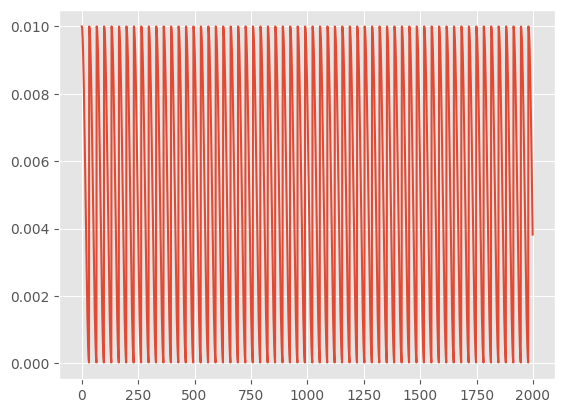

In [326]:
epochs = 200
num_cycles = 6
total_steps = len(data_loader)*epochs
print(total_steps)
print(len(data_loader))
schedule_fn = make_cyclical_lr_fn(lr_0, epochs, num_cycles)
lrs = []
cycle_ends = []
for i in range(total_steps):
    curr_lr = schedule_fn(i)
    lrs.append(curr_lr)
    if curr_lr == 0.0:
        cycle_ends.append(i)

plt.plot(lrs)

In [322]:
lrs[33]

DeviceArray(0.01, dtype=float32, weak_type=True)

##### ResNet Model

In [ ]:
rng_key = jax.random.PRNGKey(seed)
epochs = 1000
num_cycles = 7
batch_size = 80
beta = 0.7
lr_0 = 1e-3
num_blocks = 1
hidden_dims = [1000, 500]
temp, sigma = 1e-2, 1.0

torch.manual_seed(seed)
data_loader = NumpyLoader(NumpyData(X_train, y_train), batch_size=batch_size, shuffle=True)
val_data = NumpyData(X_val, y_val)

bnn_model, state, val_losses = train_resnet_model(rng_key, data_loader, val_data, epochs, num_cycles, beta, lr_0, num_blocks,
                                                  hidden_dims, dropout_rate=0.0, act_fn=jax.nn.swish, patience=20)

In [ ]:
rmse_val, r2_val = eval_bnn_model(rng_key, bnn_model, X_val, y_val, state)
rmse_test, r2_test = eval_bnn_model(rng_key, bnn_model, X_test, y_test, state)
print(f"Val RMSE: {rmse_val}, r2_score: {r2_val}")
print(f"Test RMSE: {rmse_test}, r2_score: {r2_test}")

In [ ]:
def train_deep_ens_model(rng_key, train_loader, val_data, epochs, num_cycles, beta, lr_0,
                         hidden_sizes, num_ensembles=4, dropout_rate=0.0, act_fn=jax.nn.relu, patience=20):

    
    subkeys = jax.random.split(rng_key, num_ensembles)
    ens_models = []
    ens_states = []

    val_losses = []
    for ens_key in subkeys:
        model, state, val_loss = train_nn_model(ens_key, train_loader, val_data, epochs, num_cycles, beta, lr_0,
                                            hidden_sizes, dropout_rate=dropout_rate, act_fn=act_fn, patience=patience)

        ens_models.append(model)
        ens_states.append(state)
        val_losses.append(val_loss)
        
    return ens_models, ens_states, val_losses


def train_resnet_deep_ens_model(rng_key, train_loader, val_data, epochs, num_cycles, beta, lr_0,
                                num_blocks, hidden_dim, output_dim, num_ensembles=4, dropout_rate=0.3, act_fn=jax.nn.relu, patience=20):

    
    subkeys = jax.random.split(rng_key, num_ensembles)
    ens_models = []
    ens_states = []

    val_losses = []
    for ens_key in subkeys:
        model, state, val_loss = train_resnet_model(rng_key, train_loader, val_data, epochs, num_cycles, beta, lr_0, num_blocks,
                                                    hidden_dim, output_dim, dropout_rate=dropout_rate, act_fn=act_fn, patience=patience)

        ens_models.append(model)
        ens_states.append(state)
        val_losses.append(val_loss)
        
    return ens_models, ens_states, val_losses

def eval_deep_ens_model(rng_key, models, X, y, ens_states):
    y_preds = np.zeros((len(models), len(y)))

    for i, (model, state) in enumerate(zip(models, ens_states)):
        preds, _ = model.apply(state.avg_params, state.net_state, X, rng_key, is_training=False)
        preds_mean, preds_std = jnp.split(preds, [1], axis=-1)
        preds_mean = preds_mean.squeeze()
        y_preds[i] = preds_mean

    y_preds = np.mean(y_preds, axis=0)

    rmse = jnp.sqrt(jnp.mean((y - y_preds)**2))
    r2 = r2_score(y, y_preds)

    return rmse, r2

In [ ]:
rng_key = jax.random.PRNGKey(seed)
epochs = 1000
num_cycles = 3
batch_size = 80
beta = 0.80
lr_0 = 1e-3
hidden_sizes = [1000, 500, 300, 100]
temp, sigma = 1e-2, 1.0

torch.manual_seed(seed)
data_loader = NumpyLoader(NumpyData(X_train, y_train), batch_size=batch_size, shuffle=True)
val_data = NumpyData(X_val, y_val)
models, states, val_losses = train_deep_ens_model(rng_key, data_loader, val_data, epochs, num_cycles, beta, lr_0,
                                        hidden_sizes, dropout_rate=0.0, act_fn=jax.nn.swish, num_ensembles=5, patience=20)

In [ ]:
for loss in val_losses:
    plt.plot(loss)

In [ ]:
rmse_val, r2_val = eval_deep_ens_model(rng_key, models, X_val, y_val, states)
rmse_test, r2_test = eval_deep_ens_model(rng_key, models, X_test, y_test, states)
print(f"Val RMSE: {rmse_val}, r2_score: {r2_val}")
print(f"Test RMSE: {rmse_test}, r2_score: {r2_test}")

In [ ]:
for model, state in zip(models, states):
    rmse_val, r2_val = eval_bnn_model(rng_key, model, X_val, y_val, state)
    rmse_test, r2_test = eval_bnn_model(rng_key, model, X_test, y_test, state)
    print(f"Val RMSE: {rmse_val}, r2_score: {r2_val}")
    print(f"Test RMSE: {rmse_test}, r2_score: {r2_test}")

In [ ]:
J = np.load(f"{data_dir}/cell_line/cancer_genes_net.npy")
np.count_nonzero(J)

In [ ]:
def disc_sgd_gradient_update(step_size_fn,
                         momentum_decay=0.,
                         preconditioner=None):
  """Optax implementation of the SGD optimizer.
  """

  if preconditioner is None:
    preconditioner = get_identity_preconditioner()

  def init_fn(gamma):
    return OptaxSGLDState(
        count=jnp.zeros([], jnp.int32),
        momentum=jax.tree_map(jnp.zeros_like, gamma),
        preconditioner_state=preconditioner.init(gamma))

  def update_fn(key, gamma, gradient, state):
    lr = step_size_fn(state.count)
    lr_sqrt = jnp.sqrt(lr)

    preconditioner_state = preconditioner.update_preconditioner(
        gradient, state.preconditioner_state)

    def update_momentum(m, g):
      return momentum_decay * m + g * lr_sqrt
      
    def proposal(theta, g, step_size):
        diff = (0.5*g*-(2*theta - 1)) - (1./(2*step_size))
        prob = jax.nn.sigmoid(diff)
        prob_inv = 1 - prob
        prob = prob[...,None]
        prob_inv = prob_inv[...,None]
        delta = jnp.argmax(jnp.concatenate([prob, prob_inv], axis=1), axis=-1)  

        theta_delta = (1 - theta)*delta + theta*(1 - delta)
        return theta_delta*1.

    momentum = jax.tree_map(update_momentum, state.momentum, gradient)
    # updates = preconditioner.multiply_by_m_inv(momentum, preconditioner_state)
    # updates = jax.tree_map(lambda m: m * lr_sqrt, updates)
    gamma = proposal(gamma, gradient, lr)

    return gamma, OptaxSGLDState(
        count=state.count + 1,
        momentum=momentum,
        preconditioner_state=preconditioner_state)

  return GradientTransformation(init_fn, update_fn)


def disc_sgld_gradient_update(step_size_fn, 
                         momentum_decay=0.,
                         preconditioner=None):
  """Optax implementation of the SGLD optimizer.

  If momentum_decay is set to zero, we get the SGLD method [1]. Otherwise,
  we get the underdamped SGLD (SGHMC) method [2].

  Args:
    step_size_fn: a function taking training step as input and prodng the
      step size as output.
    seed: int, random seed.
    momentum_decay: float, momentum decay parameter (default: 0).
    preconditioner: Preconditioner, an object representing the preconditioner
      or None; if None, identity preconditioner is used (default: None).  [1]
        "Bayesian Learning via Stochastic Gradient Langevin Dynamics" Max
        Welling, Yee Whye Teh; ICML 2011  [2] "Stochastic Gradient Hamiltonian
        Monte Carlo" Tianqi Chen, Emily B. Fox, Carlos Guestrin; ICML 2014
  """

  if preconditioner is None:
    preconditioner = get_identity_preconditioner()

  def init_fn(gamma):
    return OptaxSGLDState(
        count=jnp.zeros([], jnp.int32),
        momentum=jax.tree_map(jnp.zeros_like, gamma),
        preconditioner_state=preconditioner.init(gamma))

  def update_fn(key, gamma, gradient, state):
    lr = step_size_fn(state.count)
    lr_sqrt = jnp.sqrt(lr)

    preconditioner_state = preconditioner.update_preconditioner(
        gradient, state.preconditioner_state)

    def update_momentum(m, g):
      return momentum_decay * m + g * lr_sqrt
      
    def proposal(key, theta, g, step_size):
        diff = (-0.5*g*(2*theta - 1)) - (1./(2*step_size))
        delta = jax.random.bernoulli(key, jax.nn.sigmoid(diff))
        theta_delta = (1 - theta)*delta + theta*(1 - delta)
        return theta_delta*1.



    momentum = jax.tree_map(update_momentum, state.momentum, gradient)
    # updates = preconditioner.multiply_by_m_inv(momentum, preconditioner_state)
    # updates = jax.tree_map(lambda m: m * lr_sqrt, updates)
    gamma = proposal(key, gamma, gradient, lr)


    return gamma, OptaxSGLDState(
        count=state.count + 1,
        momentum=momentum,
        preconditioner_state=preconditioner_state)

  return GradientTransformation(init_fn, update_fn)


#### BNN with BG

In [ ]:
from typing import Any

Pytree = Any

class BgTrainingState(NamedTuple):
  params: hk.Params
  avg_params: hk.Params
  opt_state: optax.OptState
  net_state: hk.State
  disc_state: Pytree
  avg_disc_state: Pytree
  disc_opt_state: OptaxSGLDState

class BgBayesNN():
    def __init__(self, sgd_optim, sgld_optim, disc_sgd_optim, disc_sgld_optim, 
                        weight_prior, temp,
                        hidden_sizes, J, eta, mu, act_fn=jax.nn.relu):
        self.hidden_sizes = hidden_sizes
        self.act_fn = act_fn
        self.sgd_optim = sgd_optim
        self.sgld_optim = sgld_optim
        self.optimiser = sgd_optim

        self.disc_optimiser = disc_sgd_optim
        self.disc_sgd_optim = disc_sgd_optim
        self.disc_sgld_optim = disc_sgld_optim

        self._forward = hk.transform_with_state(self._forward_fn)
        self.loss = jax.jit(self.loss)
        self.update = jax.jit(self.update)

        self.add_noise = False
        self.J = J
        self.eta = eta
        self.mu = mu

        self.temperature = temp
        self.weight_prior = weight_prior
        # weight_decay = self.sigma*self.temperature
        # self.weight_prior = tfd.Normal(0, self.sigma)
        # self.weight_prior = tfd.StudentT(df=2, loc=0, scale=self.sigma)
        # self.weight_prior = tfd.Horseshoe(scale=self.sigma)
        # self.weight_prior = tfd.Laplace(0, self.sigma)

    def init(self, rng, x):
        gamma = tfd.Bernoulli(0.5*jnp.ones(x.shape[-1])).sample(seed=rng)*1.
        params, net_state = self._forward.init(rng, x, gamma, is_training=True)
        opt_state = self.optimiser.init(params)
        disc_opt_state = self.disc_optimiser.init(gamma)
        return BgTrainingState(params, params, opt_state, net_state, gamma, gamma, disc_opt_state)

    def apply(self, params, net_state, key, gamma, x, is_training):
        return self._forward.apply(params, net_state, key, x, gamma, is_training)


    def update(self, key, train_state, x, y):
        if self.add_noise:
            self.optimiser = self.sgld_optim
            self.disc_optimiser = self.disc_sgld_optim
        else:
            self.optimiser = self.sgd_optim
            self.disc_optimiser = self.disc_sgd_optim
        
        params, avg_params, opt_state, net_state, gamma, avg_gamma, disc_opt_state = train_state
        grads, net_state = jax.grad(self.loss, has_aux=True)(params, net_state, key, gamma, x, y)
        updates, opt_state = self.optimiser.update(grads, opt_state)
        params = optax.apply_updates(params, updates)
        avg_params = optax.incremental_update(params, avg_params, step_size=0.001)

        disc_grads, net_state = jax.grad(self.disc_loss, has_aux=True)(gamma, params, net_state, key, x, y)
        gamma, disc_opt_state = self.disc_optimiser.update(key, gamma, disc_grads, disc_opt_state)
        avg_gamma = optax.incremental_update(gamma, avg_gamma, step_size=0.01)
        return BgTrainingState(params, avg_params, opt_state, net_state, gamma, avg_gamma, disc_opt_state)

    def _forward_fn(self, x, gamma, is_training=True):
        x = x @ jnp.diag(gamma)
        init_fn = hk.initializers.VarianceScaling()
        for hd in self.hidden_sizes:
            x = hk.Linear(hd, w_init = init_fn)(x)
            
            # x = hk.BatchNorm(False, False, 0.9)(x, is_training)
            x = self.act_fn(x)

        x = hk.Linear(2)(x)
        return x

    def loss(self, params, net_state, key, gamma, x, y, is_training=True):
        preds, state = self.apply(params, net_state, key, gamma, x, is_training)
        preds_mean, preds_std = jnp.split(preds, [1], axis=-1)
        preds_std = jax.nn.softplus(preds_std.squeeze())
        tempered_var = (preds_std * jnp.sqrt(self.temperature))**2
        preds_mean = preds_mean.squeeze()
        # se = (y - preds_mean)**2
        # log_likelihood = (-0.5*se / (preds_std**2) - 
        #                  0.5*jnp.log((preds_std**2)*2*jnp.pi))
        # log_likelihood = jnp.sum(log_likelihood)
        # preds = preds.squeeze()
        # l2_loss = jnp.mean(optax.l2_loss(y, preds))
        # l2_reg =  l2_regulariser = 0.5 * sum(
        #         jnp.sum(jnp.square(p)) for p in jax.tree_util.tree_leaves(params))
        
        log_likelihood = jnp.sum(tfd.Normal(preds_mean, tempered_var).log_prob(y))
        # batch_size = x.shape[0]
        # log_likelihood = (self.data_size / batch_size)*log_likelihood
        log_prior = self.log_prior(params)

        return log_likelihood + log_prior, state

    def log_prior(self, params):
        """Computes the Gaussian prior log-density."""
        logprob_tree = jax.tree_util.tree_leaves(jax.tree_util.tree_map(lambda x: jnp.sum(self.weight_prior.log_prob(x.reshape(-1))/self.temperature), 
                                                                            params))
        
        return sum(logprob_tree)

    def disc_loss(self, gamma, params, net_state, key, x, y):
        log_ll, state = self.loss(params, net_state, key, gamma, x, y)
        log_prior = self.ising_prior(gamma)

        return (log_prior + log_ll) / self.temperature, state

    def ising_prior(self, gamma):
        """Log probability of the Ising model - prior over the discrete variables"""
        return (self.eta*(gamma.T @ self.J @ gamma) + mu*jnp.sum(gamma))


In [ ]:
class BGResNet:
    def __init__(self, sgd_optim, sgld_optim, disc_sgd_optim, disc_sgld_optim,
                 num_blocks, hidden_dim, skip_dim, J, eta, mu, act_fn=jax.nn.relu, dropout_rate=0.0):
        self.hidden_sizes = hidden_sizes
        self.act_fn = act_fn
        self.sgd_optim = sgd_optim
        self.sgld_optim = sgld_optim
        self.optimiser = sgd_optim

        self.num_blocks = num_blocks
        self.hidden_dim = hidden_dim
        self.skip_dim = skip_dim
        self.dropout_rate = dropout_rate

        self.disc_optimiser = disc_sgd_optim
        self.disc_sgd_optim = disc_sgd_optim
        self.disc_sgld_optim = disc_sgld_optim

        self._forward = hk.transform_with_state(self._forward_fn)
        self.loss = jax.jit(self.loss)
        self.update = jax.jit(self.update)

        self.add_noise = False
        self.J = J
        self.eta = eta
        self.mu = mu

        # weight_decay = self.sigma*self.temperature
        # self.weight_prior = tfd.Normal(0, self.sigma)
        # self.weight_prior = tfd.StudentT(df=2, loc=0, scale=self.sigma)
        # self.weight_prior = tfd.Horseshoe(scale=self.sigma)
        # self.weight_prior = tfd.Laplace(0, self.sigma)

    def init(self, rng, x):
        gamma = tfd.Bernoulli(0.5*jnp.ones(x.shape[-1])).sample(seed=rng)*1.
        params, net_state = self._forward.init(rng, x, gamma, is_training=True)
        opt_state = self.optimiser.init(params)
        disc_opt_state = self.disc_optimiser.init(gamma)
        return BgTrainingState(params, params, opt_state, net_state, gamma, gamma, disc_opt_state)

    def apply(self, params, net_state, key, gamma, x, is_training):
        return self._forward.apply(params, net_state, key, x, gamma, is_training)


    def update(self, key, train_state, x, y):
        if self.add_noise:
            self.optimiser = self.sgld_optim
            self.disc_optimiser = self.disc_sgld_optim
        else:
            self.optimiser = self.sgd_optim
            self.disc_optimiser = self.disc_sgd_optim

        params, avg_params, opt_state, net_state, gamma, avg_gamma, disc_opt_state = train_state
        grads, net_state = jax.grad(self.loss, has_aux=True)(params, net_state, key, gamma, x, y)
        updates, opt_state = self.optimiser.update(grads, opt_state)
        params = optax.apply_updates(params, updates)
        avg_params = optax.incremental_update(params, avg_params, step_size=0.001)

        disc_grads, net_state = jax.grad(self.disc_loss, has_aux=True)(gamma, params, net_state, key, x, y)
        gamma, disc_opt_state = self.disc_optimiser.update(key, gamma, disc_grads, disc_opt_state)
        avg_gamma = optax.incremental_update(gamma, avg_gamma, step_size=0.01)
        return BgTrainingState(params, avg_params, opt_state, net_state, gamma, avg_gamma, disc_opt_state)

    def _forward_fn(self, x, gamma, is_training=True):
        x = x @ jnp.diag(gamma)
        init_fn = hk.initializers.VarianceScaling()
        x = hk.Linear(self.skip_dim, w_init=init_fn)(x)
        for _ in range(self.num_blocks):
            z = x
            z = ResNetBlock(self.act_fn, self.hidden_dim, self.skip_dim, self.dropout_rate)(z, is_training)
            x = x + z

        x = hk.BatchNorm(False, False, 0.9)(x, is_training)
        x = self.act_fn(x)
        x = hk.Linear(2)(x)

        return x

    def loss(self, params, net_state, key, gamma, x, y, is_training=True):
        preds, state = self.apply(params, net_state, key, gamma, x, is_training)
        preds_mean, preds_std = jnp.split(preds, [1], axis=-1)
        preds_std = jax.nn.softplus(preds_std)
        preds_mean = preds_mean.squeeze()
        se = (y - preds_mean)**2
        log_likelihood = (-0.5*se / (preds_std**2) -
                          0.5*jnp.log((preds_std**2)*2*jnp.pi))
        log_likelihood = jnp.sum(log_likelihood)
        # preds = preds.squeeze()
        # l2_loss = jnp.mean(optax.l2_loss(y, preds))
        # l2_reg =  l2_regulariser = 0.5 * sum(
        #         jnp.sum(jnp.square(p)) for p in jax.tree_util.tree_leaves(params))

        return -log_likelihood, state

    def log_prior(self, params):
        """Computes the Gaussian prior log-density."""
        logprob_tree = jax.tree_util.tree_leaves(jax.tree_util.tree_map(lambda x: jnp.sum(self.weight_prior.log_prob(x.reshape(-1))/self.temperature),
                                                                        params))

        return sum(logprob_tree)

    def disc_loss(self, gamma, params, net_state, key, x, y):
        log_ll, state = self.loss(params, net_state, key, gamma, x, y)
        log_prior = self.ising_prior(gamma)

        return log_prior - log_ll, state

    def ising_prior(self, gamma):
        """Log probability of the Ising model - prior over the discrete variables"""
        return (self.eta*(gamma.T @ self.J @ gamma) + mu*jnp.sum(gamma))


In [ ]:
def train_bg_bnn_model(rng_key, train_loader, val_data, epochs, num_cycles, num_models, lr_0,
                        disc_lr_0, weight_prior, temp, hidden_sizes, eta, mu, J, act_fn=jax.nn.relu, patience=20):

    num_batches = len(train_loader)
    total_steps = num_batches*epochs
    cycle_len = epochs // num_cycles
    print(cycle_len)
    step_size_fn = make_cyclical_lr_fn(lr_0, total_steps, num_cycles)
    disc_step_size_fn = make_cyclical_lr_fn(disc_lr_0, total_steps, num_cycles)

    # step_size_fn = lambda c: lr_0
    # disc_step_size_fn = lambda c: disc_lr_0

    sgld_optim = optax.chain(optax.scale_by_schedule(step_size_fn),  optax.adam(lr_0), optax.scale(-1.0))
    sgd_optim = optax.chain(optax.scale_by_schedule(step_size_fn),  optax.adam(lr_0), optax.scale(-1.0))

    # sgd_optim = sgd_gradient_update(step_size_fn, momentum_decay=0, preconditioner=get_rmsprop_preconditioner())
    # sgld_optim = sgld_gradient_update(step_size_fn, momentum_decay=0, preconditioner=get_rmsprop_preconditioner())
    
    disc_sgd_optim = disc_sgd_gradient_update(disc_step_size_fn, momentum_decay=0, preconditioner=get_identity_preconditioner())
    disc_sgld_optim = disc_sgld_gradient_update(disc_step_size_fn, momentum_decay=0, preconditioner=get_identity_preconditioner())


    model = BgBayesNN(sgd_optim, sgld_optim, disc_sgd_optim, disc_sgld_optim,
                        weight_prior, temp,
                        hidden_sizes, J, eta, mu, act_fn=act_fn)

    train_state = model.init(rng_key, next(iter(train_loader))[0])

    val_losses = []
    lrs = []
    key = rng_key
    early_stopping = 0
    step = 0
    states = []
    for epoch in range(epochs):
        for batch_x, batch_y in train_loader:
            _, key = jax.random.split(key, 2)
            train_state = model.update(key, train_state, batch_x, batch_y)
            step += 1
        val_loss, _  = eval_bg_bnn_model(key, model, val_data.data, val_data.target, train_state)
        c_lr = step_size_fn(step)
        lrs.append(c_lr)
        if (epoch % cycle_len) + 1 > (cycle_len - num_models):
            states.append(train_state)

        if epoch != 0 and (val_loss > val_losses[-1]):
            early_stopping += 1
            if early_stopping > patience:
                print(f"Stopping at epoch: {epoch}, Total train steps: {step}")
                break
        else:
            early_stopping = 0 #reset

        val_losses.append(val_loss)

    print(f"Total number of steps trained: {step}")

    return model, states, val_losses, lrs

def train_bg_bnn_model_v2(rng_key, train_loader, val_data, epochs, lr_0,
                       disc_lr_0, weight_prior, temp, hidden_sizes, eta, mu, J, act_fn=jax.nn.relu, patience=20):

    num_batches = len(train_loader)

    step_size_fn = lambda c: lr_0
    disc_step_size_fn = lambda c: disc_lr_0

    sgld_optim = optax.chain(optax.scale_by_schedule(step_size_fn),  optax.adam(lr_0), optax.scale(-1.0))
    sgd_optim = optax.chain(optax.scale_by_schedule(step_size_fn),  optax.adam(lr_0), optax.scale(-1.0))



    disc_sgd_optim = disc_sgd_gradient_update(disc_step_size_fn, momentum_decay=0, preconditioner=get_identity_preconditioner())
    disc_sgld_optim = disc_sgld_gradient_update(disc_step_size_fn, momentum_decay=0, preconditioner=get_identity_preconditioner())


    model = BgBayesNN(sgd_optim, sgld_optim, disc_sgd_optim, disc_sgld_optim,
                      weight_prior, temp,
                      hidden_sizes, J, eta, mu, act_fn=act_fn)

    train_state = model.init(rng_key, next(iter(train_loader))[0])

    val_losses = []
    key = rng_key
    early_stopping = 0
    step = 0

    for epoch in range(epochs):
        for batch_x, batch_y in train_loader:
            _, key = jax.random.split(key, 2)
            train_state = model.update(key, train_state, batch_x, batch_y)
            step += 1
        val_loss, _  = eval_bg_bnn_model(key, model, val_data.data, val_data.target, train_state)
        if epoch != 0 and (val_loss > val_losses[-1]):
            early_stopping += 1
            if early_stopping > patience:
                # print(f"Stopping at epoch: {epoch}, Total train steps: {step}")
                break
        else:
            early_stopping = 0 #reset

        val_losses.append(val_loss)

    # print(f"Total number of steps trained: {step}")

    return model, train_state, val_losses


def eval_bg_bnn_model(rng_key, model, X, y, state):
    # disc_state = jax.random.bernoulli(rng_key, state.avg_disc_state)
    preds, _ = model.apply(state.params, state.net_state, rng_key, state.disc_state, X, is_training=False)
    preds_mean, preds_std = jnp.split(preds, [1], axis=-1)
    preds_mean = preds_mean.squeeze()

    rmse = jnp.sqrt(jnp.mean((y - preds_mean)**2))
    r2 = r2_score(y, preds_mean)

    return rmse, r2

def eval_per_model_score(rng_key, model, X, y, ens_states):
    y_preds = np.zeros(len(y))

    for i, state in enumerate(ens_states):
        # disc_state = jax.random.bernoulli(rng_key, state.avg_disc_state)
        preds, _ = model.apply(state.params, state.net_state, rng_key, state.disc_state, X, is_training=False)
        preds_mean, preds_std = jnp.split(preds, [1], axis=-1)
        preds_mean = preds_mean.squeeze()
        y_preds += preds_mean

    y_preds = y_preds / len(ens_states)

    rmse = jnp.sqrt(jnp.mean((y - y_preds)**2))
    r2 = r2_score(y, y_preds)

    return rmse, r2



##### BG + NN model

In [ ]:
rng_key = jax.random.PRNGKey(seed)
epochs = 1000
num_cycles = 10
batch_size = 80
num_models = 79
lr_0, disc_lr_0 = 1e-3, 0.8
hidden_sizes = [1000, 500, 300, 100]
eta, mu = 10.0, 1.0

temp, sigma = 1.0, 1.0
weight_prior = tfd.StudentT(df=2, loc=0, scale=sigma)

torch.manual_seed(seed)
data_loader = NumpyLoader(NumpyData(X_train, y_train), batch_size=batch_size, shuffle=True)
val_data = NumpyData(X_val, y_val)
bg_bnn_model, states, val_losses, lrs = train_bg_bnn_model(rng_key, data_loader, val_data, epochs, num_cycles, num_models, lr_0, disc_lr_0,
                                                        weight_prior, sigma,
                                                        hidden_sizes, eta, mu, J, act_fn=jax.nn.swish)

len(states)                                            

In [ ]:
rmse_val, r2_val = eval_per_model_score(rng_key, bg_bnn_model, X_val, y_val, states)
rmse_test, r2_test = eval_per_model_score(rng_key, bg_bnn_model, X_test, y_test, states)
print(f"Val  RMSE: {rmse_val}, r2_score: {r2_val}")
print(f"Test RMSE: {rmse_test}, r2_score: {r2_test}")

In [ ]:
for state in states:
    rmse_val, r2_val = eval_bg_bnn_model(rng_key, bg_bnn_model, X_val, y_val, state)
    rmse_test, r2_test = eval_bg_bnn_model(rng_key, bg_bnn_model, X_test, y_test, state)
    print(f"Val  RMSE: {rmse_val}, r2_score: {r2_val}")
    print(f"Test RMSE: {rmse_test}, r2_score: {r2_test}")

In [ ]:
from operator import itemgetter

def train_bg_deep_ens_model(rng_key, train_loader, val_data, epochs, lr_0, disc_lr_0,
                            weight_prior, temp, hidden_sizes, eta, mu, J, act_fn=jax.nn.relu, patience=20, num_ensembles=5):

    
    subkeys = jax.random.split(rng_key, num_ensembles)
    ens_models = []
    ens_states = []

    val_losses = []

    for ens_key in subkeys:
        model, state, val_loss = train_bg_bnn_model_v2(ens_key, train_loader, val_data, epochs, lr_0, disc_lr_0,
                                                    weight_prior, temp, hidden_sizes, eta, mu, J, act_fn=act_fn, patience=patience)

        ens_models.append(model)
        ens_states.append(state)
        val_losses.append(val_loss)

    return ens_models, ens_states, val_losses

def eval_bg_deep_ens_model(rng_key, models, X, y, ens_states):
    y_preds = np.zeros((len(models), len(y)))

    for i, (model, state) in enumerate(zip(models, ens_states)):
        # disc_state = jax.random.bernoulli(rng_key, state.avg_disc_state)
        preds, _ = model.apply(state.params, state.net_state, rng_key, state.disc_state, X, is_training=False)
        preds_mean, preds_std = jnp.split(preds, [1], axis=-1)
        preds_mean = preds_mean.squeeze()
        y_preds[i] = preds_mean

    y_preds = np.mean(y_preds, axis=0)

    rmse = jnp.sqrt(jnp.mean((y - y_preds)**2))
    r2 = r2_score(y, y_preds)

    return rmse, r2


def get_feats_dropout_loss(models, states, X, y):

    def eval_fn(models, X, y, ens_states, p, on=True):
        y_preds = np.zeros((len(models), len(y)))
        for i, (models, state) in enumerate(zip(models, ens_states)):
            disc_state = state.disc_state
            if not on:
                disc_state = disc_state.at[p].set(0)
            # disc_state = jax.random.bernoulli(rng_key, state.avg_disc_state)
            preds, _ = model.apply(state.params, state.net_state, rng_key,  disc_state, X, is_training=False)
            preds_mean, preds_std = jnp.split(preds, [1], axis=-1)
            preds_mean = preds_mean.squeeze()
            y_preds[i] = preds_mean

        y_preds = np.mean(y_preds, axis=0)

        rmse = jnp.sqrt(jnp.mean((y - y_preds)**2))
        return rmse


    var_loss_dict = {"feats_idx": [], "num_models": [] , "loss_on": [], "loss_off": [], "loss_diff": []}
    disc_states  = np.array([state.disc_state for state in states])
    # mean_gammas = np.mean(disc_states, axis=0)
    # idxs = np.argwhere(mean_gammas == 1.0).ravel()
    p = X.shape[-1]

    for idx in range(p):
        loss_diff = 0.0
        idx_on = np.argwhere(disc_states[:,idx] == 1.).ravel()
        loss_on, loss_off = 0., 0.
        if idx_on.size == 0: ## irrelevant feature
            loss_diff = 1e9
        else:
            models_on = itemgetter(*idx_on)(models)
            states_on = itemgetter(*idx_on)(states)
            if idx_on.size == 1:
                models_on = [models_on]
                states_on = [states_on]
            loss_on += eval_fn(models_on, X, y, states_on, idx)
            loss_off += eval_fn(models_on, X, y, states_on, idx, on=False)
            loss_diff += (loss_on - loss_off)

        var_loss_dict["feats_idx"].append(idx)
        var_loss_dict["num_models"].append(idx_on.size)
        var_loss_dict["loss_on"].append(loss_on)
        var_loss_dict["loss_off"].append(loss_off)
        var_loss_dict["loss_diff"].append(loss_diff)


    var_loss_df = pd.DataFrame(var_loss_dict).sort_values(by="loss_diff")

    return var_loss_df

##### Deep Ensembles

In [ ]:
import torch
rng_key = jax.random.PRNGKey(seed)
epochs = 500
num_cycles = 4
batch_size = 80
num_models = 5
lr_0, disc_lr_0 = 1e-3, 0.8
hidden_sizes = [1000, 500, 300, 100]
eta, mu = 10.0, 1.0

temp, sigma = 1.0, 1.0
weight_prior = tfd.StudentT(df=2, loc=0, scale=sigma)

torch.manual_seed(seed)
data_loader = NumpyLoader(NumpyData(X_train, y_train), batch_size=batch_size, shuffle=True)
val_data = NumpyData(X_val, y_val)
bg_bnn_models, bg_states, val_losses = train_bg_deep_ens_model(rng_key, data_loader, val_data, epochs, lr_0, disc_lr_0,
                                                               weight_prior, temp, hidden_sizes, eta, mu, J, num_ensembles=20, act_fn=jax.nn.swish, patience=10)

In [ ]:
for i, loss in enumerate(val_losses):
    plt.plot(loss, label=f"Ens - {i}")

# plt.legend()

In [ ]:
rmse_val, r2_val = eval_bg_deep_ens_model(rng_key, bg_bnn_models, X_val, y_val, bg_states)
rmse_test, r2_test = eval_bg_deep_ens_model(rng_key, bg_bnn_models, X_test, y_test, bg_states)
print(f"Val  RMSE: {rmse_val}, r2_score: {r2_val}")
print(f"Test RMSE: {rmse_test}, r2_score: {r2_test}")

In [ ]:
for model, state in zip(bg_bnn_models, bg_states):
    rmse_val, r2_val = eval_bg_bnn_model(rng_key, model, X_val, y_val, state)
    rmse_test, r2_test = eval_bg_bnn_model(rng_key, model, X_test, y_test, state)
    print(f"Val  RMSE: {rmse_val}, r2_score: {r2_val}")
    print(f"Test RMSE: {rmse_test}, r2_score: {r2_test}")

In [ ]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV, KFold
from sklearn.metrics import r2_score

def train_rf_model(seed, X, y):

    cv = KFold(n_splits=5, random_state=seed, shuffle=True)

    param_grid = {
        'bootstrap': [True],
        'max_depth': [80, 90, 100, 110],
        'max_features': [2, 3],
        'min_samples_leaf': [3, 4, 5],
        'min_samples_split': [8, 10, 12],
        'n_estimators': [100, 200, 300, 1000]
    }

    rf_reg = RandomForestRegressor(random_state=seed, max_samples=1.0)
    grid_cv = GridSearchCV(estimator = rf_reg, param_grid = param_grid,
                           cv = cv, n_jobs = -1, verbose = 0, scoring="r2").fit(X, y)

    rf_reg = RandomForestRegressor(random_state=seed, max_samples=1.0,**grid_cv.best_params_)
    rf_reg.fit(X, y)

    return rf_reg

def eval_rf_model(model, X, y):
    y_preds = model.predict(X)
    rmse = jnp.sqrt(jnp.mean((y - y_preds)**2))
    r2 = r2_score(y, y_preds)
    return rmse, r2

In [ ]:
rf_model = train_rf_model(seed, X_train, y_train)

rmse_val, r2_val = eval_rf_model(rf_model, X_val, y_val)
rmse_test, r2_test = eval_rf_model(rf_model, X_test, y_test)

print(f"Val RMSE: {rmse_val}, r2_score:  {r2_val}")
print(f"Test RMSE: {rmse_test}, test_score:  {r2_test}")

In [ ]:
np.quantile(mean_gammas, q=[0., 0.25, 0.5, 0.95, 1.])

In [ ]:
bnn_feat_idx = np.argsort(mean_gammas)[::-1][:50]
# bnn_feat_idx = dropout_loss_df["feats_idx"][:10].to_list()
# X_train_df.iloc[:, bnn_feat_idx].columns.to_list()

In [ ]:
rf_feat_idx = np.argsort(rf_model.feature_importances_)[::-1][:50]
# X_train_df.iloc[:, rf_feat_idx].columns.to_list()

In [ ]:
X_train_2, y_train_2 = jax.random.choice(rng_key, X_train, shape=(X_val.shape[0],), replace=False), jax.random.choice(rng_key, y_train, shape=(X_val.shape[0],), replace=False)
X_gp_train_rf, X_gp_train_2_rf, X_gp_val_rf, X_gp_test_rf = X_val[:,rf_feat_idx], X_train_2[:,rf_feat_idx], X_train[:,rf_feat_idx], X_test[:,rf_feat_idx]
rf_val_rmse_score, rf_val_r2_score, rf_val_pcc, rf_val_pval, \
    rf_test_rmse_score, rf_test_r2_score, rf_test_pcc, rf_test_pval = train_linear_model(seed, X_gp_train_2_rf, X_gp_train_rf, X_gp_test_rf, y_train_2, y_val, y_test)

print(f"val_r2_score: {rf_val_r2_score}, test_r2_score: {rf_test_r2_score}")
print(f"val_pcc: {rf_val_pcc}, pval: {rf_val_pval}, test_pcc: {rf_test_pcc}, pval: {rf_test_pval}")

In [ ]:
X_gp_train_bnn, X_gp_train_2_bnn, X_gp_val_bnn, X_gp_test_bnn = X_val[:,bnn_feat_idx], X_train_2[:,bnn_feat_idx], X_train[:,bnn_feat_idx], X_test[:,bnn_feat_idx]
bnn_val_rmse_score, bnn_val_r2_score, bnn_val_pcc, bnn_val_pval, \
         bnn_test_rmse_score, bnn_test_r2_score, bnn_test_pcc, bnn_test_pval = train_linear_model(seed, X_gp_train_2_bnn, X_gp_train_bnn, X_gp_test_bnn, y_train_2, y_val, y_test)

print(f"val_r2_score: {bnn_val_r2_score}, test_r2_score: {bnn_test_r2_score}")
print(f"val_pcc: {bnn_val_pcc}, pval: {bnn_val_pval}, test_pcc: {bnn_test_pcc}, pval: {bnn_test_pval}")

In [ ]:
rf_gp_val_rmse_score, rf_gp_val_r2_score, rf_gp_val_pcc, rf_gp_val_pval, \
         rf_gp_test_rmse_score, rf_gp_test_r2_score, rf_gp_test_pcc, rf_gp_test_pval, gp_df = train_gp(seed, X_gp_train_rf, X_gp_train_2_rf, X_gp_val_rf, X_gp_test_rf, 
                                                                                                      y_val, y_train_2, y_train, y_test, num_models=5, verbose=1, 
                                                                                                      p_cxvr=0.8, p_subt_mut=0.1, p_hmut=0.05, p_pmut=0.05, complexity_coef=0.01)

print(f"val_r2_score: {rf_gp_val_r2_score}, test_r2_score: {rf_gp_test_r2_score}")
print(f"val_pcc: {rf_gp_val_pcc}, test_pcc: {rf_gp_test_pcc}")

In [ ]:
bnn_gp_val_rmse_score, bnn_gp_val_r2_score, bnn_gp_val_pcc, bnn_gp_val_pval, \
         bnn_gp_test_rmse_score, bnn_gp_test_r2_score, bnn_gp_test_pcc, bnn_gp_test_pval, gp_df = train_gp(seed, X_gp_train_bnn, X_gp_train_2_bnn, X_gp_val_bnn, X_gp_test_bnn, 
                                                                                                      y_val, y_train_2, y_train, y_test, num_models=5, verbose=1, p_cxvr=0.8, p_subt_mut=0.1, 
                                                                                                      p_hmut=0.05, p_pmut=0.05, complexity_coef=0.01)

print(f"val_r2_score: {bnn_gp_val_r2_score}, test_r2_score: {bnn_gp_test_r2_score}")
print(f"val_pcc: {bnn_gp_val_pcc}, test_pcc: {bnn_gp_test_pcc}")

In [ ]:
print(f"val_r2_score: {bnn_gp_val_r2_score}, test_r2_score: {bnn_gp_test_r2_score}")
print(f"val_pcc: {bnn_gp_val_pcc}, test_pcc: {bnn_gp_test_pcc}")

In [ ]:
gp_df

In [ ]:
X_train_df.iloc[:,np.array(bnn_feat_idx)[[53, 5, 44]]]

In [ ]:
bnn_feat_idx[5]

In [ ]:
from operator import itemgetter

def evaluate_bnn_bg_models(model, X, y, params, gammas):
    eval_fn = lambda p, g: model.apply(p, g, X).ravel()
    preds = jax.vmap(eval_fn)(params, gammas)
    preds = preds.reshape(-1, preds.shape[-1])
    losses = jax.vmap(optax.l2_loss, in_axes=(0, None))(preds, y)
    mean_loss = jnp.sqrt(jnp.mean(losses, axis=-1))
    return jnp.sum(mean_loss)

def get_feats_dropout_loss(models, states, X, y):

    def eval_fn(model, X, y, ens_states, p, on=True):
        y_preds = np.zeros(len(y))

        for i, state in enumerate(ens_states):
            # disc_state = jax.random.bernoulli(rng_key, state.avg_disc_state)
            disc_state = state.disc_state
            if not on:
                disc_state = disc_state.at[:,p].set(0)
            preds, _ = model.apply(state.params, state.net_state, rng_key, disc_state, X, is_training=False)
            preds_mean, preds_std = jnp.split(preds, [1], axis=-1)
            preds_mean = preds_mean.squeeze()
            y_preds += preds_mean

        y_preds = y_preds / len(ens_states)

        rmse = jnp.sqrt(jnp.mean((y - y_preds)**2))
        return rmse


    var_loss_dict = {"feats_idx": [], "num_models": [] , "loss_on": [], "loss_off": [], "loss_diff": []}
    disc_states  = np.array([state.disc_state for state in states])
    p = X.shape[1]

    for idx in range(p):
        loss_diff = 0.0
        idx_on = np.argwhere(disc_states[:,idx] == 1.).ravel()
        loss_on, loss_off = 0., 0.
        if idx_on.size == 0: ## irrelevant feature
            loss_diff = 1e9
        else:
            models_on = itemgetter(*idx_on)(models)
            states_on = itemgetter(*idx_on)(states)
            for (model, state) in zip(models_on, states_on):
                loss_on += eval_fn(model, X, y, state, idx)
                loss_off += eval_fn(model, X, y, state, idx, on=False)
                loss_diff += (loss_on - loss_off)


        var_loss_dict["feats_idx"].append(idx)
        var_loss_dict["num_models"].append(idx_on.size)
        var_loss_dict["loss_on"].append(loss_on)
        var_loss_dict["loss_off"].append(loss_off)
        var_loss_dict["loss_diff"].append(loss_diff)


    var_loss_df = pd.DataFrame(var_loss_dict).sort_values(by="loss_diff")

    return var_loss_df

def get_gene_names(gene_cols):
    return [gene.split("(")[0].strip() for gene in gene_cols]

In [ ]:
from smac.facade.smac_hpo_facade import SMAC4HPO
from smac.scenario.scenario import Scenario
from smac.configspace import ConfigurationSpace
from ConfigSpace.hyperparameters import (
    CategoricalHyperparameter,
    UniformFloatHyperparameter,
    UniformIntegerHyperparameter,
)

from ConfigSpace import InCondition, Configuration

import math

def get_configspace_bnn_bg()-> ConfigurationSpace:
    
    # Build Configuration Space which defines all parameters and their ranges.
    cs  = ConfigurationSpace()    
    mu = CategoricalHyperparameter("mu", [1., 5., 10.], default_value=1.)
    temp = CategoricalHyperparameter("temp", [1e-4, 1e-3, 1e-2, 1e-1, 1.0], default_value=1e-3)
    cs.add_hyperparameters([temp, mu])
    return cs

def get_configspace_bnn()-> ConfigurationSpace:
    
    # Build Configuration Space which defines all parameters and their ranges.
    cs  = ConfigurationSpace()    
    temp = CategoricalHyperparameter("temp", [1e-4, 1e-3, 1e-2, 1e-1, 1.], default_value=1e-3)
    cs.add_hyperparameters([temp])
    return cs

def generate_train_bnn_bg_cs(seed, X, y, J):
    cv = KFold(n_splits=3, shuffle=True, random_state=seed)
    def train_cs(config: Configuration)-> float:
        epochs = 2000
        num_cycles = 10
        bathc_size = 80
        beta = 0.99
        lr_0, disc_lr_0 = 1e-3, 0.8
        hidden_sizes = [1000, 500, 300, 100]
        sigma = 1.0
        eta = 1.0

        scores = []

        for train_idx, test_idx in cv.split(X, y):
            x_train_cv, y_train_cv = X[train_idx], y[train_idx]
            x_test_cv, y_test_cv = X[test_idx], y[test_idx]
            bg_bnn_model, states, disc_states = train_bg_bnn_model(seed, x_train_cv, y_train_cv, epochs,
                                                                     num_cycles, beta, lr_0, disc_lr_0,
                                                                     batch_size, hidden_sizes, config["temp"], sigma, eta, config["mu"], J)
            
            _, r2 = eval_bg_bnn_model(bg_bnn_model, x_test_cv, y_test_cv, states, disc_states)
            scores.append(r2)

        mean_score = np.mean(np.array(scores))
        if math.isnan(mean_score) or mean_score < 0:
            return 1e9
        
        return 1 - mean_score


    return train_cs

def generate_train_bnn_cs(seed, X, y):
    cv = KFold(n_splits=3, shuffle=True, random_state=seed)
    def train_cs(config: Configuration)-> float:
        epochs = 2000
        num_cycles = 10
        bathc_size = 80
        beta = 0.99
        lr_0 = 1e-3
        hidden_sizes = [1000, 500, 300, 100]
        sigma = 1.0

        scores = []

        for train_idx, test_idx in cv.split(X, y):
            x_train_cv, y_train_cv = X[train_idx], y[train_idx]
            x_test_cv, y_test_cv = X[test_idx], y[test_idx]
            bnn_model, states = train_bnn_model(seed, x_train_cv, y_train_cv, epochs, num_cycles, beta, lr_0,
                                                    batch_size, hidden_sizes, config["temp"], sigma)
            
            _, r2 = eval_bnn_model(bnn_model, x_test_cv, y_test_cv, states)
            scores.append(r2)

        mean_score = np.mean(np.array(scores))
        if math.isnan(mean_score) or mean_score < 0:
            return 1e9
        
        return 1 - mean_score


    return train_cs


def optimize_hyper_parameters(seed, X, y, J, total_time=60, bg=True):
    if bg:
        cs = get_configspace_bnn_bg()
        train_cs = generate_train_bnn_bg_cs(seed, X, y, J)
    else:
        cs = get_configspace_bnn()
        train_cs = generate_train_bnn_cs(seed, X, y)

    scenario = Scenario({
        "run_obj": "quality",
        "wallclock-limit": total_time,
        "cs": cs,
        "deterministic": True,
        "cutoff": 10,  # runtime limit for the target algorithm
        "seed": seed
    })

    smac = SMAC4HPO(scenario=scenario, rng=np.random.RandomState(seed), tae_runner=train_cs)

    tae = smac.get_tae_runner()

    try:
        incumbent = smac.optimize()

    finally:
        incumbent = smac.solver.incumbent


    inc_val = tae.run(config=incumbent, seed=seed)

    return incumbent, 1 - inc_val[1]


In [ ]:
# config, score = optimize_hyper_parameters(seed, X_train, y_train, J, total_time=180)
# score

In [ ]:
from tqdm import tqdm
from sklearn.preprocessing import QuantileTransformer
from sklearn.metrics import r2_score
# epochs = 2000
# num_cycles = 10
# batch_size = 80
# beta = 0.99
# lr_0, disc_lr_0 = 1e-3, 0.5
# hidden_sizes = [1000, 500, 300, 10]
# sigma = 1.0
# eta, mu = 1.0, 1.0
# temp = 1e-3
epochs = 1000
num_cycles = 10
batch_size = 80
beta = 0.80
lr_0, disc_lr_0 = 1e-3, 0.5
hidden_sizes = [1000, 500, 300, 100]
temp, sigma = 1e-2, 1.0
eta, mu = 1.0, 1.0


def cross_val_run(seeds, X, y):

    bnn_rf_bg_dict = {"seed":[], "model": [], "val_rmse": [], "test_rmse": [], "val_r2_score": [], "test_r2_score": [], "temp": [], "mu": []}

    for seed in tqdm(seeds):
        X_train_df, X_test_df, y_train_df, y_test_df = train_test_split(X, y, random_state=seed, shuffle=True, test_size=0.2)
        X_train_df, X_val_df, y_train_df, y_val_df = train_test_split(X_train_df, y_train_df, shuffle=True, 
                                                    random_state=seed, test_size=0.2)
        # train_transformer = PowerTransformer().fit(X_train_df)
        train_transformer = QuantileTransformer(random_state=seed, output_distribution="normal").fit(X_train_df)
        train_transformed = train_transformer.transform(X_train_df)
        val_transformed = train_transformer.transform(X_val_df)
        test_transformed = train_transformer.transform(X_test_df)

        X_train_df = pd.DataFrame(train_transformed, columns=X_train_df.columns)
        X_val_df = pd.DataFrame(val_transformed, columns=X_val_df.columns)
        X_test_df = pd.DataFrame(test_transformed, columns=X_test_df.columns)
        X_train, y_train = X_train_df.values, y_train_df.values
        X_val, y_val = X_val_df.values, y_val_df.values
        X_test, y_test = X_test_df.values, y_test_df.values


        # config_bnn_bg, score = optimize_hyper_parameters(seed, X_train, y_train, J, total_time=180, bg=True)
        bg_bnn_model, states, disc_states = train_bg_bnn_model(seed, X_train, y_train, epochs, num_cycles, beta, lr_0, disc_lr_0,
                                                                        batch_size, hidden_sizes, temp, sigma, eta, mu, J)

        rmse_val_bnn_bg, r2_val_bnn_bg = eval_bg_bnn_model(bg_bnn_model, X_val, y_val, states, disc_states)
        rmse_test_bnn_bg, r2_test_bnn_bg = eval_bg_bnn_model(bg_bnn_model, X_test, y_test, states, disc_states)

        # config_bnn, score = optimize_hyper_parameters(seed, X_train, y_train, J, total_time=180, bg=False)
        bnn_model, states = train_bnn_model(seed, X_train, y_train, epochs, num_cycles, beta, lr_0,
                                                batch_size, hidden_sizes, temp, sigma)

        rmse_val_bnn, r2_val_bnn = eval_bnn_model(bnn_model, X_val, y_val, states)
        rmse_test_bnn, r2_test_bnn = eval_bnn_model(bnn_model, X_test, y_test, states)

        rf_model = train_rf_model(seed, X_train, y_train)
        rmse_val_rf, r2_val_rf = eval_rf_model(rf_model, X_val, y_val)
        rmse_test_rf, r2_test_rf = eval_rf_model(rf_model, X_test, y_test)

        bnn_rf_bg_dict["seed"].append(seed)
        bnn_rf_bg_dict["model"].append("RF")
        bnn_rf_bg_dict["val_rmse"].append(rmse_val_rf)
        bnn_rf_bg_dict["test_rmse"].append(rmse_test_rf)
        bnn_rf_bg_dict["val_r2_score"].append(r2_val_rf)
        bnn_rf_bg_dict["test_r2_score"].append(r2_test_rf)
        bnn_rf_bg_dict["temp"].append(0.0)
        bnn_rf_bg_dict["mu"].append(0.0)

        bnn_rf_bg_dict["seed"].append(seed)
        bnn_rf_bg_dict["model"].append("BNN")
        bnn_rf_bg_dict["val_rmse"].append(rmse_val_bnn)
        bnn_rf_bg_dict["test_rmse"].append(rmse_test_bnn)
        bnn_rf_bg_dict["val_r2_score"].append(r2_val_bnn)
        bnn_rf_bg_dict["test_r2_score"].append(r2_test_bnn)
        bnn_rf_bg_dict["temp"].append(temp)
        bnn_rf_bg_dict["mu"].append(0.0)

        bnn_rf_bg_dict["seed"].append(seed)
        bnn_rf_bg_dict["model"].append("BNN + BG")
        bnn_rf_bg_dict["val_rmse"].append(rmse_val_bnn_bg)
        bnn_rf_bg_dict["test_rmse"].append(rmse_test_bnn_bg)
        bnn_rf_bg_dict["val_r2_score"].append(r2_val_bnn_bg)
        bnn_rf_bg_dict["test_r2_score"].append(r2_test_bnn_bg)
        bnn_rf_bg_dict["temp"].append(temp)
        bnn_rf_bg_dict["mu"].append(mu)

        print(f"RF scores - Val: {r2_val_rf}, Test: {r2_test_rf}")
        print(f"BNN scores - Val: {r2_val_bnn}, Test: {r2_test_bnn}")
        print(f"BNN + BG scores - Val: {r2_val_bnn_bg}, Test: {r2_test_bnn_bg}")

        
    return pd.DataFrame(bnn_rf_bg_dict)

In [ ]:
# seeds = [422,261,968,282,739,573,220,413,745,775,482,442,210,423,760,57,769,920,226,196]
# bnn_rf_bg_df = cross_val_run(seeds, X_selected, target)
save_dir = f"{data_dir}/exp_data_5/cancer/gdsc"
# bnn_rf_bg_df.to_csv(f"{save_dir}/bnn_rf_bg_df_v5.csv", index=False)

In [ ]:
bnn_rf_bg_df = pd.read_csv(f"{save_dir}/bnn_rf_bg_df_v5.csv")
bnn_rf_bg_df.groupby("model").mean().iloc[:,1:]

In [ ]:
bnn_rf_bg_df.groupby(["model"])["val_r2_score" ,"test_r2_score"].mean()

In [ ]:
labels = ["RF", "BNN", "BNN + BG"]

rf_val_r2_scores, rf_test_r2_scores = bnn_rf_bg_df[bnn_rf_bg_df["model"] == "RF"]["val_r2_score"], \
                                               bnn_rf_bg_df[bnn_rf_bg_df["model"] == "RF"]["test_r2_score"]

bnn_val_r2_scores, bnn_test_r2_scores = bnn_rf_bg_df[bnn_rf_bg_df["model"] == "BNN"]["val_r2_score"], \
                                                  bnn_rf_bg_df[bnn_rf_bg_df["model"] == "BNN"]["test_r2_score"]

bnn_bg_val_r2_scores, bnn_bg_test_r2_scores = bnn_rf_bg_df[bnn_rf_bg_df["model"] == "BNN + BG"]["val_r2_score"], \
                                                  bnn_rf_bg_df[bnn_rf_bg_df["model"] == "BNN + BG"]["test_r2_score"]                                              

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

ax1.grid(color='grey', axis='y', linestyle='-', linewidth=0.25, alpha=0.5)
ax2.grid(color='grey', axis='y', linestyle='-', linewidth=0.25, alpha=0.5)

bplot1 = ax1.boxplot([rf_val_r2_scores, bnn_val_r2_scores, bnn_bg_val_r2_scores], showmeans=True, patch_artist=True, labels=labels)
bplot2 = ax2.boxplot([rf_test_r2_scores, bnn_test_r2_scores, bnn_bg_test_r2_scores], showmeans=True, patch_artist=True, labels=labels)

# fill with colors
colors = ['lightyellow' ,'lightblue', 'lightgreen']
for bplot in (bplot1, bplot2):
    for patch, color in zip(bplot['boxes'], colors):
        patch.set_facecolor(color)

fig.suptitle("Model Comparison")
plt.legend([bplot1['medians'][0], bplot1['means'][0]], ['median', 'mean'])

ax1.set_ylabel("$R^{2}$")
ax1.set_title("Validation Scores")

ax2.set_ylabel("$R^{2}$")
ax2.set_title("Test Scores")

plt.show()

In [ ]:
from scipy import stats

stats.ttest_rel(bnn_bg_test_r2_scores, rf_test_r2_scores, alternative="greater")

#### GP

In [ ]:
from gplearn.genetic import SymbolicTransformer, SymbolicClassifier, SymbolicRegressor
from gplearn.functions import make_function
import operator
from sklearn.linear_model import Ridge
from sklearn.model_selection import GridSearchCV
from scipy import stats
import warnings
warnings.filterwarnings("ignore")

def get_best_programs(gp, num_models, classifier=True, ascending=True, sort_fit="OOB_fitness"):
    gp_dict = {'Gen': [], "Ind": [], "Fitness": [], 'OOB_fitness': [], "Equation": []}

    if classifier:
        for idGen in range(len(gp._programs)):
            for idPopulation in range(gp.population_size):
                gp_dict["Gen"].append(idGen)
                gp_dict["Ind"].append(idPopulation)
                gp_dict["Fitness"].append(gp._programs[idGen][idPopulation].fitness_)
                gp_dict["OOB_fitness"].append(gp._programs[idGen][idPopulation].oob_fitness_)
                gp_dict["Equation"].append(str(gp._programs[idGen][idPopulation]))
    else:
        for idx, prog in enumerate(gp._programs[-1]):
                gp_dict["Gen"].append(-1)
                gp_dict["Ind"].append(idx)
                gp_dict["Fitness"].append(prog.fitness_)
                gp_dict["OOB_fitness"].append(prog.oob_fitness_)
                gp_dict["Equation"].append(str(prog))

    gp_df = pd.DataFrame(gp_dict).sort_values(sort_fit, ascending=ascending)[:num_models]
    programs = []
    for i in range(num_models):
        gen, ind = int(gp_df.iloc[i]["Gen"]), int(gp_df.iloc[i]["Ind"])
        programs.append(gp._programs[gen][ind])

    return programs, gp_df


def gp_transform(est, X, classifier=False, num_models=100, sort_fit="Fitness"):
    if classifier or (sort_fit == "OOB_fitness"):
        programs, gp_df = get_best_programs(est, num_models, classifier, sort_fit=sort_fit, ascending=classifier)
        out = np.zeros((X.shape[0], len(programs)))
        for i, prog in enumerate(programs):
            out[:, i] = prog.execute(X)

        return out, gp_df
    else:
        return est.transform(X), None

function_set = ['add', 'sub', 'mul', 'div', 'sqrt', 'log',
                'abs', 'neg', 'inv', 'max', 'min']

def train_linear_model(seed, X_train, X_test, y_train, y_test):
    cv = KFold(n_splits=3, random_state=seed, shuffle=True)
    param_grid = {"alpha": np.logspace(-2, 2, 20)}
    grid_cv = GridSearchCV(estimator=Ridge(max_iter=10000), param_grid=param_grid, 
                                            verbose=0, scoring="r2", cv=cv).fit(X_train, y_train)
    lin_model = Ridge(max_iter=10000, **grid_cv.best_params_)
    lin_model.fit(X_train, y_train)
    y_test_pred = lin_model.predict(X_test)

    test_rmse_score = np.sqrt(np.mean((y_test - y_test_pred)**2))
    test_r2_score = r2_score(y_test, y_test_pred)
    test_pearson, test_pval = stats.pearsonr(y_test, y_test_pred)

    return test_rmse_score, test_r2_score, test_pearson, test_pval

def train_gp(seed, X_train, X_train_2, X_test, y_train, y_train_2, y_test, num_models=5, sort_fit="OOB_fitness", verbose=0, num_gen=100, 
                        p_cxvr=0.8, p_subt_mut=0.1, p_hmut=0.05, p_pmut=0.1, subsample=0.8, complexity_coef=0.05):
    gp_est = SymbolicTransformer(population_size=1000, hall_of_fame=200, n_components=50, generations=num_gen,
                           p_crossover=p_cxvr, p_subtree_mutation=p_subt_mut,
                           p_hoist_mutation=p_hmut, p_point_mutation=p_pmut,
                           max_samples=subsample, verbose=verbose,
                           parsimony_coefficient=complexity_coef, random_state=seed)

    gp_est.fit(X_train, y_train)

    gp_features_train, gp_train_df = gp_transform(gp_est, X_train_2, classifier=False, sort_fit=sort_fit, num_models=num_models)
    gp_features_test, gp_test_df = gp_transform(gp_est, X_test, classifier=False, sort_fit=sort_fit, num_models=num_models)

    X_train_comb = np.concatenate([X_train_2, gp_features_train], axis=1)
    X_test_comb = np.concatenate([X_test, gp_features_test], axis=1)


    test_rmse_score, test_r2_score, test_pearson, test_pval = train_linear_model(seed, X_train_comb, X_test_comb, y_train_2, y_test)

    return test_rmse_score, test_r2_score, test_pearson, test_pval, gp_test_df


In [ ]:
from tqdm import tqdm
import pickle
from sklearn.preprocessing import QuantileTransformer
from scipy.stats import pearsonr
epochs = 500
batch_size = 80
num_models = 5
lr_0, disc_lr_0 = 1e-3, 0.8
hidden_sizes = [1000, 500, 300, 100]
eta, mu = 10.0, 1.0

temp, sigma = 1.0, 1.0
weight_prior = tfd.StudentT(df=2, loc=0, scale=sigma)
num_feats = [20, 40, 60]
num_ens = 10

save_dir = f"{data_dir}/exp_data_5/cancer/gdsc"

def cross_val_gp_train(seeds, X, y):
   
   bnn_rf_gp_dict = {"seed": [], "model": [], "num_feats": [], "test_rmse_score": [], 
                    "test_r2_score": [], "test_pcc": [], "test_pcc_pval": []}

   bnn_bg_rf_dict = {"seed":[], "model": [], "val_rmse": [], "test_rmse": [], "val_r2_score": [], "test_r2_score": []}

   for seed in tqdm(seeds):
      rng_key = jax.random.PRNGKey(seed)
      X_train_df, X_test_df, y_train_df, y_test_df = train_test_split(X, y, random_state=seed, shuffle=True, test_size=0.2)
      X_train_df, X_val_df, y_train_df, y_val_df = train_test_split(X_train_df, y_train_df, shuffle=True, 
                                                   random_state=seed, test_size=0.2)
      train_transformer = QuantileTransformer(random_state=seed, output_distribution="normal").fit(X_train_df)
      train_transformed = train_transformer.transform(X_train_df)
      val_transformed = train_transformer.transform(X_val_df)
      test_transformed = train_transformer.transform(X_test_df)

      X_train_df = pd.DataFrame(train_transformed, columns=X_train_df.columns)
      X_val_df = pd.DataFrame(val_transformed, columns=X_val_df.columns)
      X_test_df = pd.DataFrame(test_transformed, columns=X_test_df.columns)
      X_train, y_train = X_train_df.values, y_train_df.values
      X_val, y_val = X_val_df.values, y_val_df.values
      X_test, y_test = X_test_df.values, y_test_df.values

      # Train BNN and RF models and select features
      torch.manual_seed(seed)
      data_loader = NumpyLoader(NumpyData(X_train, y_train), batch_size=batch_size, shuffle=True)
      val_data = NumpyData(X_val, y_val)

      bg_bnn_models, bg_states, val_losses = train_bg_deep_ens_model(rng_key, data_loader, val_data, epochs, lr_0, disc_lr_0,
                                                                     weight_prior, temp, hidden_sizes, eta, mu, J, num_ensembles=num_ens, act_fn=jax.nn.swish, patience=10)
      
      bnn_bg_rmse_val, bnn_bg_r2_val = eval_bg_deep_ens_model(rng_key, bg_bnn_models, X_val, y_val, bg_states)
      bnn_bg_rmse_test, bnn_bg_r2_test = eval_bg_deep_ens_model(rng_key, bg_bnn_models, X_test, y_test, bg_states)

      gammas = np.array([state.avg_disc_state for state in bg_states])
      mean_gammas = np.mean(gammas, axis=0)
      

      rf_model = train_rf_model(seed, X_train, y_train)
      rf_rmse_val, rf_r2_val = eval_rf_model(rf_model, X_val, y_val)
      rf_rmse_test, rf_r2_test = eval_rf_model(rf_model, X_test, y_test)

      X_train_2, y_train_2 = jax.random.choice(rng_key, X_train, shape=(X_val.shape[0],), replace=False), jax.random.choice(rng_key, y_train, shape=(X_val.shape[0],), replace=False)

      for num_feat in num_feats:
         bnn_feat_idx = np.argsort(mean_gammas)[::-1][:num_feat]

         rf_feat_idx = np.argsort(rf_model.feature_importances_)[::-1][:num_feat]

         # Create new validation for training Linear Regression models same size as outer validation
         X_gp_train_rf, X_gp_train_2_rf, X_gp_val_rf, X_gp_test_rf = X_val[:,rf_feat_idx], X_train_2[:,rf_feat_idx], X_train[:,rf_feat_idx], X_test[:,rf_feat_idx] 
         X_gp_train_bnn, X_gp_train_2_bnn, X_gp_val_bnn, X_gp_test_bnn = X_val[:,bnn_feat_idx], X_train_2[:,bnn_feat_idx], X_train[:,bnn_feat_idx], X_test[:,bnn_feat_idx]
         
         y_train_gp, y_train_gp_2, y_val_gp, y_test_gp = y_val, y_train_2, y_train, y_test

         ## Run GP

   
         bnn_test_rmse_score, bnn_test_r2_score, bnn_test_pcc, bnn_test_pval = train_linear_model(seed, X_gp_train_2_bnn, X_gp_test_bnn, y_train_gp_2, y_test_gp)
         rf_test_rmse_score, rf_test_r2_score, rf_test_pcc, rf_test_pval = train_linear_model(seed, X_gp_train_2_rf, X_gp_test_rf, y_train_gp_2, y_test_gp)


         bnn_gp_test_rmse_score, bnn_gp_test_r2_score, bnn_gp_test_pcc, bnn_gp_test_pval, _ = train_gp(seed, X_gp_train_bnn, X_gp_train_2_bnn, X_gp_test_bnn, 
                                                                                                               y_train_gp, y_train_gp_2, y_test_gp, num_models=num_models, verbose=0, p_cxvr=0.8, p_subt_mut=0.1, 
                                                                                                               p_hmut=0.05, p_pmut=0.05, complexity_coef=0.01)


         rf_gp_test_rmse_score, rf_gp_test_r2_score, rf_gp_test_pcc, rf_gp_test_pval, _ = train_gp(seed, X_gp_train_rf, X_gp_train_2_rf, X_gp_test_rf, 
                                                                                                               y_train_gp, y_train_gp_2, y_test_gp, num_models=num_models, verbose=0, p_cxvr=0.8, p_subt_mut=0.1, 
                                                                                                               p_hmut=0.05, p_pmut=0.05, complexity_coef=0.01)


         # ======================== Save scores for compressed models =========================

         bnn_rf_gp_dict["seed"].append(seed)
         bnn_rf_gp_dict["model"].append("RF + LR")
         bnn_rf_gp_dict["num_feats"].append(num_feat)
         bnn_rf_gp_dict["test_rmse_score"].append(rf_test_rmse_score)
         bnn_rf_gp_dict["test_r2_score"].append(rf_test_r2_score)
         bnn_rf_gp_dict["test_pcc"].append(rf_test_pcc)
         bnn_rf_gp_dict["test_pcc_pval"].append(rf_test_pval)

         bnn_rf_gp_dict["seed"].append(seed)
         bnn_rf_gp_dict["model"].append("RF + LR + GP")
         bnn_rf_gp_dict["num_feats"].append(num_feat)
         bnn_rf_gp_dict["test_rmse_score"].append(rf_gp_test_rmse_score)
         bnn_rf_gp_dict["test_r2_score"].append(rf_gp_test_r2_score)
         bnn_rf_gp_dict["test_pcc"].append(rf_gp_test_pcc)
         bnn_rf_gp_dict["test_pcc_pval"].append(rf_gp_test_pval)

         bnn_rf_gp_dict["seed"].append(seed)
         bnn_rf_gp_dict["model"].append("BNN + LR")
         bnn_rf_gp_dict["num_feats"].append(num_feat)
         bnn_rf_gp_dict["test_rmse_score"].append(bnn_test_rmse_score)
         bnn_rf_gp_dict["test_r2_score"].append(bnn_test_r2_score)
         bnn_rf_gp_dict["test_pcc"].append(bnn_test_pcc)
         bnn_rf_gp_dict["test_pcc_pval"].append(bnn_test_pval)


         bnn_rf_gp_dict["seed"].append(seed)
         bnn_rf_gp_dict["model"].append("BNN + LR + GP")
         bnn_rf_gp_dict["num_feats"].append(num_feat)
         bnn_rf_gp_dict["test_rmse_score"].append(bnn_gp_test_rmse_score)
         bnn_rf_gp_dict["test_r2_score"].append(bnn_gp_test_r2_score)
         bnn_rf_gp_dict["test_pcc"].append(bnn_gp_test_pcc)
         bnn_rf_gp_dict["test_pcc_pval"].append(bnn_gp_test_pval)


         print(f"RF scores - LR: {rf_test_r2_score} GP: {rf_gp_test_r2_score}")
         print(f"BNN scores - LR: {bnn_test_r2_score} GP: {bnn_gp_test_r2_score}")


      # ======================== Save scores for non-compressed models =========================
      bnn_rf_deep_ens_bg_dict["seed"].append(seed)
      bnn_rf_deep_ens_bg_dict["model"].append("RF")
      bnn_rf_deep_ens_bg_dict["val_rmse"].append(rf_rmse_val)
      bnn_rf_deep_ens_bg_dict["val_r2_score"].append(rf_r2_val)
      bnn_rf_deep_ens_bg_dict["test_rmse"].append(rf_rmse_test)
      bnn_rf_deep_ens_bg_dict["test_r2_score"].append(rf_r2_test)

      bnn_rf_deep_ens_bg_dict["seed"].append(seed)
      bnn_rf_deep_ens_bg_dict["model"].append("Deep Ens")
      bnn_rf_deep_ens_bg_dict["val_rmse"].append(bnn_bg_rmse_val)
      bnn_rf_deep_ens_bg_dict["val_r2_score"].append(bnn_bg_r2_val)
      bnn_rf_deep_ens_bg_dict["test_rmse"].append(bnn_bg_rmse_test)
      bnn_rf_deep_ens_bg_dict["test_r2_score"].append(bnn_bg_r2_test)



   return bnn_rf_deep_ens_bg_dict, bnn_rf_gp_dict

In [ ]:
# seeds = [422,261,968,282,739,573,220,413,745,775,482,442,210,423,760,57,769,920,226,196]
seeds = [422,261,968,282,739]
bnn_rf_deep_ens_bg_dict, bnn_rf_gp_dict = cross_val_gp_train(seeds, X_selected, target)
save_dir = f"{data_dir}/exp_data_5/cancer/gdsc"
bnn_rf_gp_df = pd.DataFrame(bnn_rf_gp_dict)
bnn_rf_gp_df.to_csv(f"{save_dir}/bnn_rf_gp_df_avg_state_v2.csv", index=False)
bnn_rf_deep_ens_bg_df = pd.DataFrame(bnn_rf_deep_ens_bg_dict)
bnn_rf_deep_ens_bg_df.to_csv(f"{save_dir}/bnn_deep_ens_rf.csv", index=False)

In [ ]:
bnn_rf_deep_ens_bg_df = pd.read_csv(f"{save_dir}/bnn_deep_ens_rf.csv")
bnn_rf_deep_ens_bg_df.drop(index=[36, 37]).groupby("model").mean()

In [ ]:
pd.read_csv(f"{save_dir}/bnn_deep_ens_rf.csv")

In [ ]:
save_dir = f"{data_dir}/exp_data_5/cancer/gdsc"
bnn_rf_gp_df = pd.read_csv(f"{save_dir}/bnn_rf_gp_df_avg_state_v2.csv")
bnn_rf_gp_df.groupby(["model", "num_feats"]).mean().iloc[:,1:]

In [ ]:
bnn_rf_gp_df.groupby(["model"]).mean().iloc[:,1:]

In [ ]:
bnn_rf_deep_ens_bg_df.iloc[37]

In [ ]:
bnn_rf_gp_df_2 = pd.read_csv(f"{save_dir}/bnn_rf_gp_df_avg_state.csv")
bnn_rf_gp_df_2.groupby("model").mean().iloc[:,1:]

In [ ]:
def input_mapping(x, B):
  if B is None:
    return x
  else:
    def transform_fn(x):
      x_proj = (2.*jnp.pi*x) * B
      return jnp.concatenate([jnp.sin(x_proj), jnp.cos(x_proj)], axis=-1)

    x_fft = jax.vmap(transform_fn)(x)
    return x_fft


In [ ]:
rng_key = jax.random.PRNGKey(seed)
epochs = 1000
num_cycles = 3
batch_size = 80
beta = 0.8
lr_0 = 1e-3
hidden_sizes = [1000, 500, 300, 100]
temp, sigma = 1e-2, 1.0
n, p = X_train.shape

# scales = [1.0, 10., 100.0]
scales = [15, 20, 50]

for scale in scales:
    B_gauss = scale*jax.random.normal(rng_key, (p,))
    X_train_fft = input_mapping(X_train, B_gauss)
    X_val_fft = input_mapping(X_val, B_gauss)
    X_test_fft = input_mapping(X_test, B_gauss)
    X_train_fft.shape
    torch.manual_seed(seed)
    data_loader = NumpyLoader(NumpyData(X_train_fft, y_train), batch_size=batch_size, shuffle=True)
    val_data = NumpyData(X_val_fft, y_val)

    bnn_model, state, val_losses = train_nn_model(rng_key, data_loader, val_data, epochs, num_cycles, beta, lr_0,
                                        hidden_sizes, dropout_rate=0.0, act_fn=jax.nn.swish, patience=20)

    rmse_val, r2_val = eval_bnn_model(rng_key, bnn_model, X_val_fft, y_val, state)
    rmse_test, r2_test = eval_bnn_model(rng_key, bnn_model, X_test_fft, y_test, state)
    print(f"Scale: {scale}")
    print(f"Val RMSE: {rmse_val}, r2_score: {r2_val}")
    print(f"Test RMSE: {rmse_test}, r2_score: {r2_test}")                                    

In [ ]:
rng_key = jax.random.PRNGKey(seed)
n, p = X_train.shape
B_gauss = 10.*jax.random.normal(rng_key, (p, ))

In [ ]:
X_train_fft = input_mapping(X_train, B_gauss)

In [ ]:
X_train_fft.shape